In [73]:
reset -fs

In [74]:
#NLTK
import nltk
import nltk
nltk.download('punkt')
nltk.download('wordnet')
  
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

#Gensim
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

from collections import Counter
import string

#sklearn
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer



#pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

#Other
import pandas as pd
import numpy as np
import re, string
import zipfile
import os
import matplotlib 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

[nltk_data] Error loading punkt: <urlopen error [Errno 8] nodename nor
[nltk_data]     servname provided, or not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


### Data pre-processing

- Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
- Words that have fewer than 3 characters are removed.
- All stopwords are removed.
 - Stop words list has been extended after running a baseline LDA model 
- Words are __stemmed__ — words are reduced to their root form.


In [809]:
# Create the list of stopwords and extend it 

stopwords = list(ENGLISH_STOP_WORDS)
# Adding "just" after running basic LDA model
newStopWords = [ 'realli', 'highli', 'recommend', 'great', 'didn',\
            'just', 'like','wast', 'time','easi', 'know',\
               'excit', 'love', 'money', 'want', \
               'pretty', 'thank', 'worth', 'good', # counselor pops up
                 'disappoint', 'look',
               'thing', 'took', 'need',
               'peac', 'use', 'cool',
               'doe', 'black', 'friday',
               'vitagen', 'andm', 'ancestri',
               'tell',
               'awesom', 'abl', 'sure',
               'super', 'happi',
               'better', 'receiv', 'came',
               'purchas', 'updat',
               'sell', 'send', 'best', 'sent', 'said',
               'answer',
               'gift',
               'saliva', 'sampl',
               'gener']
                
''' , \'sure', 'look', 'forward', 'peac',\
'vitagen',
'disappoint', 'happi', 'expect',
'littl',
'black', 'friday', 'super',
'use', 'cool','''
stopwords.extend(newStopWords)



def tokenize(text):
    """
    Tokenize text and return a non-unique list of tokenized words
    found in the text.
    Normalize to lowercase, strip punctuation,
    remove stop words, drop words of length < 3.
    """
    
    text=text.lower() #Convert everything to lowercase
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)  # delete stuff but leave at least a space to avoid clumping together
    words =  nltk.word_tokenize(nopunct) # tokenizing words
    words_token = [w for w in words if len(w) > 3]  # Drop words less than length 3
    words_token[:] = [w for w in words_token if w != '']
    words_stop = [w for w in words_token if w not in stopwords] # Removes stop words using SciKit-Learn's ENGLISH_STOP_WORDS set.
    words_res = [w.encode('ascii','ignore') for w in words_stop]
    return words_res

def stemwords(words):
    """
    Given a list of tokens/words, return a new list with each word
    stemmed using a PorterStemmer.
    """
    stemmer = PorterStemmer()
    words = [w.decode('ascii','ignore') for w in words]
    stemmed = [stemmer.stem(w) for w in words]
    stemmed_filtered = [w for w in stemmed if w not in stopwords]
    return stemmed_filtered

    
def tokenizer(text):
    
    return stemwords(tokenize(text))


In [ ]:
df

In [810]:
df_reviews = pd.read_csv('data/as_gp_amz_all_reviews_dna.csv')

In [811]:
len(df_reviews)

3157

In [853]:
1860+688+82

2630

In [852]:
df_reviews['name'].value_counts()

23andMe                           1860
23andMe - DNA Testing             688 
Vitagene                          340 
23andMe Health                    82  
TellmeGen                         80  
Color Heriditary Cancer Test      60  
DNAPassport - Explore Your DNA    35  
Color Genetic Risk Test           9   
CellMaxLife                       3   
Name: name, dtype: int64

In [813]:
# Extract text of reviews
reviews_text = df_reviews['text']
text = list(reviews_text)

In [814]:
clean_text = [tokenizer(n_t) for n_t in text]

In [815]:
# Adding bi-grams and tri-grams to reviews

from gensim.models.phrases import Phrases, Phraser
# Add bigrams and trigrams to docs (only ones that appear 10 times or more).
bigram = Phraser(Phrases(clean_text, min_count=10))
trigram = Phrases(bigram[clean_text])

for idx in range(len(clean_text)):
    for token in bigram[clean_text[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            clean_text[idx].append(token)
    for token in trigram[clean_text[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            clean_text[idx].append(token)

#### Remove empty tokens

In [816]:
for item in clean_text:
    item[:] = [elem for elem in item if elem != ""]


#### Create the dictionary

In [817]:
#Creating the dictionary out of corpus of reviews
dictionary = corpora.Dictionary(clean_text)

In [818]:
len(dictionary)

4204

In [819]:
# Hyperparameters

NUM_TOPICS =5 # Number of topics in negative reviews

# PArameters used in filtering the dictionaries
MIN_DF= 2 # remove tokens that appear in less than MIN_DF docs
MAX_DF = 0.5 # Remove tokens that appear in more than MAX_DF * 100% of docs

In [820]:
# Filter extremes:
# Filter tokens that appear in less than 2 doc-s
# Filter out tokens that appear in more than 30% of docs

dictionary.filter_extremes(no_below=MIN_DF, no_above= MAX_DF)



In [821]:
len(dictionary)

2441

#### Create word term matrix

In [822]:
doc_term_mx = [dictionary.doc2bow(doc) for doc in clean_text]

### LDA model training

In [823]:
# LDA for reviews

lda = gensim.models.ldamodel.LdaModel(corpus=doc_term_mx, \
                                      id2word=dictionary, num_topics=NUM_TOPICS, random_state = 17) \
                                      #, update_every=1, chunksize=100, passes=50)

In [824]:
# Topics based on all reviews
lda.print_topics(num_words=20)

[(0,
  '0.020*"famili_histori" + 0.018*"famili" + 0.015*"test" + 0.014*"product" + 0.011*"info" + 0.010*"result" + 0.010*"genet" + 0.010*"histori" + 0.010*"learn" + 0.008*"health" + 0.007*"order" + 0.007*"report" + 0.006*"weight" + 0.006*"lactos_intoler" + 0.006*"diet" + 0.006*"diet_exercis" + 0.006*"data" + 0.006*"eastern_european" + 0.006*"vitamin" + 0.005*"inform"'),
 (1,
  '0.041*"report" + 0.034*"inform" + 0.019*"test" + 0.017*"health" + 0.014*"genet" + 0.014*"result" + 0.012*"famili_member" + 0.009*"provid" + 0.009*"famili" + 0.008*"supplement" + 0.008*"question" + 0.006*"diet_exercis" + 0.006*"learn" + 0.006*"help" + 0.006*"littl" + 0.006*"compani" + 0.005*"base" + 0.005*"gene" + 0.005*"genet_counselor" + 0.005*"trait"'),
 (2,
  '0.048*"test" + 0.024*"result" + 0.015*"inform" + 0.011*"breast_cancer" + 0.009*"famili" + 0.009*"diet" + 0.009*"health" + 0.009*"cancer" + 0.008*"genet" + 0.008*"process" + 0.007*"diet_exercis" + 0.006*"question" + 0.006*"provid" + 0.006*"gene" + 0.005*

In [825]:
#Visualize negative topics
pyLDAvis.gensim.prepare(lda, doc_term_mx, dictionary, R = 20)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.042639  0.028950  1       1        28.538851
3      0.037728  0.059620  2       1        22.665319
1      0.003274 -0.085611  3       1        19.783289
2      0.018806 -0.028919  4       1        18.157133
0     -0.102448  0.025960  5       1        10.855416, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
234   Default  648.000000   report            648.000000   20.0000  20.0000
59    Default  150.000000   famili_histori    150.000000   19.0000  19.0000
151   Default  1188.000000  test              1188.000000  18.0000  18.0000
36    Default  1599.000000  result            1599.000000  17.0000  17.0000
1558  Default  130.000000   breast_cancer     130.000000   16.0000  16.0000
58    Default  371.000000   famili            371.000000   15.0000  15.0000
174   Default  885.000000   inform            885.000000   14.0000  14.0000
192   Default  261.000000   custom_servic     261.000000   13.0000  13.0000
311   Default  159.000000   famili_member     159.000000   12.0000  12.0000
33    Default  323.000000   product           323.000000   11.0000  11.0000
66    Default  99.000000    histori           99.000000    10.0000  10.0000
1657  Default  171.000000   diet              171.000000   9.0000   9.0000 
495   Default  125.000000   cancer            125.000000   8.0000   8.0000 
314   Default  234.000000   info              234.000000   7.0000   7.0000 
503   Default  56.000000    lactos_intoler    56.000000    6.0000   6.0000 
1535  Default  65.000000    weight            65.000000    5.0000   5.0000 
202   Default  409.000000   genet             409.000000   4.0000   4.0000 
143   Default  226.000000   learn             226.000000   3.0000   3.0000 
968   Default  147.000000   instruct          147.000000   2.0000   2.0000 
131   Default  368.000000   week              368.000000   1.0000   1.0000 
1640  Topic1   18.315306    protein           19.498674    1.1913  -6.6333 
1798  Topic1   10.458341    seller            11.209949    1.1845  -7.1936 
1344  Topic1   9.928163     quicker           10.747178    1.1746  -7.2456 
1908  Topic1   10.358722    schedul           11.216413    1.1744  -7.2032 
2047  Topic1   9.161104     contin            9.955985     1.1707  -7.3260 
1308  Topic1   8.773866     reaction          9.560283     1.1681  -7.3692 
1820  Topic1   8.764573     older             9.562340     1.1668  -7.3703 
1919  Topic1   7.959099     fast_deliveri     8.697318     1.1652  -7.4667 
1414  Topic1   7.133746     russian           7.908401     1.1508  -7.5762 
2014  Topic1   7.476646     quicker_expect    8.303643     1.1490  -7.5292 
...      ...        ...         ...                ...        ...      ... 
586   Topic5   6.587249     biolog_famili     8.997537     1.9087  -6.6893 
97    Topic5   18.250856    biolog_father     27.423279    1.8133  -5.6702 
503   Topic5   32.972046    lactos_intoler    56.722260    1.6780  -5.0787 
1626  Topic5   19.713715    eat               32.230392    1.7289  -5.5931 
1646  Topic5   28.144569    smell_asparagu    48.240204    1.6817  -5.2371 
66    Topic5   51.859119    histori           99.138855    1.5725  -4.6259 
1535  Topic5   34.015205    weight            65.481430    1.5655  -5.0476 
502   Topic5   15.320886    lactos            26.743378    1.6634  -5.8452 
1000  Topic5   30.406857    eastern_european  67.081818    1.4293  -5.1597 
332   Topic5   26.133745    adopt             55.292870    1.4711  -5.3112 
96    Topic5   15.223189    biolog            27.694847    1.6221  -5.8516 
386   Topic5   23.007353    friend            51.856911    1.4078  -5.4386 
58    Topic5   93.169647    famili            371.884888   0.8363  -4.0400 
33    Topic5   75.950294    product           323.064331   0.7727  -4.2443 
314   T


The left panel of the chart presents a global view of topics: how they are related to each other (far apart or inmtersect) and how preevalent they are (the larger the circle the more prevalent is the topic). 

THe right panel shows  the individual terms that are the most useful for interpreting the currently selected topic on the left.  A pair of overlaid bars represent both the corpus-wide frequency ofa given term as well as the topic-specific frequency of the term.

Parameter lambda regulates the _relevance_ of the term, which is used to rank terms within topics. It is regulated by parameter _lambda_.
- If _lambda_ = 1, we'll see familiar ranking of terms in decreasing order of their topic-specific probability
- If _lambda_ = 0, we'll rank words soleley by their _lift_, defined as the ratio of a term’s probability within a topic to its marginal probability across the corpus. In other words, it helps determine the words exclusivity to a particular topic. 

### Coherence score

In [826]:
# Compute Coherence Score
coherence_lda = CoherenceModel(model=lda, texts=clean_text, dictionary= dictionary,  coherence='c_v')
coherence_score = coherence_lda.get_coherence()
print('\nCoherence Score: ', coherence_score)




Coherence Score:  0.38461043551564833


In [827]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1, random_state = 17):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state = random_state)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


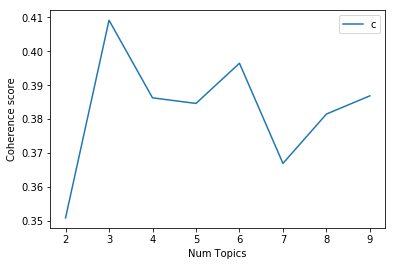

In [828]:

model_list, coherence_values = compute_coherence_values( corpus= doc_term_mx, dictionary = dictionary, texts = clean_text, limit = 10 );
# Show graph
import matplotlib.pyplot as plt
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show();


Source: 
- [https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/]
- [https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/]

In [836]:
# LDA for reviews
NUM_TOPICS = 5# 
lda = gensim.models.ldamodel.LdaModel(corpus=doc_term_mx, \
                                      id2word=dictionary, num_topics=NUM_TOPICS, random_state = 17) \
                                      #, update_every=1, chunksize=100, passes=50)
lda.print_topics(num_words=20)

[(0,
  '0.020*"famili_histori" + 0.018*"famili" + 0.015*"test" + 0.014*"product" + 0.011*"info" + 0.010*"result" + 0.010*"genet" + 0.010*"histori" + 0.010*"learn" + 0.008*"health" + 0.007*"order" + 0.007*"report" + 0.006*"weight" + 0.006*"lactos_intoler" + 0.006*"diet" + 0.006*"diet_exercis" + 0.006*"data" + 0.006*"eastern_european" + 0.006*"vitamin" + 0.005*"inform"'),
 (1,
  '0.041*"report" + 0.034*"inform" + 0.019*"test" + 0.017*"health" + 0.014*"genet" + 0.014*"result" + 0.012*"famili_member" + 0.009*"provid" + 0.009*"famili" + 0.008*"supplement" + 0.008*"question" + 0.006*"diet_exercis" + 0.006*"learn" + 0.006*"help" + 0.006*"littl" + 0.006*"compani" + 0.005*"base" + 0.005*"gene" + 0.005*"genet_counselor" + 0.005*"trait"'),
 (2,
  '0.048*"test" + 0.024*"result" + 0.015*"inform" + 0.011*"breast_cancer" + 0.009*"famili" + 0.009*"diet" + 0.009*"health" + 0.009*"cancer" + 0.008*"genet" + 0.008*"process" + 0.007*"diet_exercis" + 0.006*"question" + 0.006*"provid" + 0.006*"gene" + 0.005*

Negative topics:

- Topic 0:family history,  family, health report, lactose intolerance, diet, exercising. Unique words (lambda =0):   guide, scale, license

- Topic 1: information, learning, diet, exercising, supplement, genetic counselor (!)Unique: genetic counselor, counselor

- Topic 2: breast cancer, cancer, diseses, gene, diet, exercising . Unique: precise, allergi, platform, america, geography

- Topic 3:results, wait, week, follow instructions, ==> About the user experience, process of sending the samples and getting results. Unique: clear instructions, follow instructions

- TOpic 4: customer service, health risks, month. Unique: protein (?). describr, seller, quicker, quicker than expected, fast delivery, reaction, 

In [838]:
pyLDAvis.gensim.prepare(lda, doc_term_mx, dictionary, R = 20)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.042639  0.028950  1       1        28.555187
3      0.037728  0.059620  2       1        22.641745
1      0.003274 -0.085611  3       1        19.792879
2      0.018806 -0.028919  4       1        18.150862
0     -0.102448  0.025960  5       1        10.859327, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
234   Default  648.000000   report            648.000000   20.0000  20.0000
59    Default  151.000000   famili_histori    151.000000   19.0000  19.0000
151   Default  1188.000000  test              1188.000000  18.0000  18.0000
36    Default  1600.000000  result            1600.000000  17.0000  17.0000
1558  Default  130.000000   breast_cancer     130.000000   16.0000  16.0000
58    Default  371.000000   famili            371.000000   15.0000  15.0000
174   Default  885.000000   inform            885.000000   14.0000  14.0000
192   Default  261.000000   custom_servic     261.000000   13.0000  13.0000
311   Default  159.000000   famili_member     159.000000   12.0000  12.0000
33    Default  323.000000   product           323.000000   11.0000  11.0000
66    Default  99.000000    histori           99.000000    10.0000  10.0000
1657  Default  171.000000   diet              171.000000   9.0000   9.0000 
495   Default  125.000000   cancer            125.000000   8.0000   8.0000 
314   Default  234.000000   info              234.000000   7.0000   7.0000 
503   Default  56.000000    lactos_intoler    56.000000    6.0000   6.0000 
1535  Default  65.000000    weight            65.000000    5.0000   5.0000 
202   Default  409.000000   genet             409.000000   4.0000   4.0000 
143   Default  226.000000   learn             226.000000   3.0000   3.0000 
968   Default  147.000000   instruct          147.000000   2.0000   2.0000 
131   Default  368.000000   week              368.000000   1.0000   1.0000 
1640  Topic1   18.325790    protein           19.509121    1.1908  -6.6333 
1798  Topic1   10.464327    seller            11.215833    1.1840  -7.1936 
1344  Topic1   9.933846     quicker           10.752693    1.1741  -7.2456 
1908  Topic1   10.364652    schedul           11.222252    1.1738  -7.2032 
2047  Topic1   9.166348     contin            9.961114     1.1702  -7.3260 
1308  Topic1   8.778889     reaction          9.565211     1.1675  -7.3692 
1820  Topic1   8.769590     older             9.567284     1.1663  -7.3703 
1919  Topic1   7.963655     fast_deliveri     8.701786     1.1647  -7.4667 
1414  Topic1   7.137830     russian           7.912400     1.1503  -7.5762 
2014  Topic1   7.480926     quicker_expect    8.307749     1.1485  -7.5292 
...      ...        ...         ...                ...        ...      ... 
586   Topic5   6.589622     biolog_famili     9.000304     1.9084  -6.6893 
97    Topic5   18.257431    biolog_father     27.428156    1.8131  -5.6702 
503   Topic5   32.983925    lactos_intoler    56.743423    1.6776  -5.0787 
1626  Topic5   19.720818    eat               32.226112    1.7290  -5.5931 
1646  Topic5   28.154709    smell_asparagu    48.247425    1.6815  -5.2371 
66    Topic5   51.877800    histori           99.154022    1.5724  -4.6259 
1535  Topic5   34.027458    weight            65.488983    1.5654  -5.0476 
502   Topic5   15.326405    lactos            26.753426    1.6631  -5.8452 
1000  Topic5   30.417809    eastern_european  67.090744    1.4291  -5.1597 
332   Topic5   26.143160    adopt             55.302273    1.4709  -5.3112 
96    Topic5   15.228673    biolog            27.699139    1.6219  -5.8516 
386   Topic5   23.015640    friend            51.866707    1.4076  -5.4386 
58    Topic5   93.203209    famili            371.910309   0.8363  -4.0400 
33    Topic5   75.977654    product           323.103882   0.7726  -4.2443 
314   T

#### Determine the dominant topic for each review

In [839]:
for i, row in enumerate(lda[doc_term_mx]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Percentage Contribution and Keywords for each document
    for j, (topic_num, topic_prop) in enumerate(row):
        if j == 0:  # => dominant topic
            word_prop = lda.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, proportion in word_prop])
            
            #sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        else:
            break

In [840]:
def format_topics_documents(ldamodel, corpus, texts):
    # Init output
    doc_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Percentage Contribution and Keywords for each document
        for j, (topic_num, topic_prop) in enumerate(row):
            if j == 0:  # => dominant topic
                word_prop = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in word_prop])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(topic_prop,3), topic_keywords]), ignore_index=True)
            else:
                break
    doc_topics_df.columns = ['dominant_topic', 'perc_contribution', 'topic_keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    doc_topics_df = pd.concat([doc_topics_df, contents], axis=1)
    return(doc_topics_df)


In [858]:


df_topic_docs_keywords = format_topics_documents(ldamodel=lda, corpus=doc_term_mx, texts= text )

# Format
df_dominant_topic = df_topic_docs_keywords.reset_index()
df_dominant_topic.columns = ['doc_no', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'text']
df_dominant_topic_sorted = df_dominant_topic.sort_values(['topic_perc_contrib'], ascending=False)
df_dominant_topic_sorted.reset_index(drop=True, inplace=True)
df_to_send = df_dominant_topic_sorted[:100]
df_to_send.to_csv('100_representative_reviews.csv')
# Show




In [855]:
df_dominant_topic_sorted.head(50)

,doc_no,dominant_topic,topic_perc_contrib,keywords,text
0,1845,4.0,0.994,"result, test, health, custom_servic, inform, wait, week, report, product, servic","The DNA test itself is fine and useful IF you are looking for DNA relatives or you buy and upload results to promethease.com, which will tell you everything that is published on SNPedia about your genes and is only $5.00; BUT the company 23andme is a mess! Their website is a mess!\nIn the first place, they don't really distinguish, when setting up your account, which questions are required to set up your account and which are voluntary to help them with research. That is frustrating. A person should be able to tend to the important agreements and know they're done with those and that their account is set up before being asked what probably amounts to (not exaggerating) 10-15 hours of health questions.\nIn any case, realizing that somehow I'd gotten onto that treadmill and it wasn't going to end, I tried over the course of 3 days and put over 8 hours into attempting resolve a website glitch that would allow a person to choose whether they did or didn't want their sample stored for further research.\n\nI had friends over to see if they could figure out the problem. I called and wrote to customer service.- two different branches of the company - and they didn't seem to care. Their customer service is the worst! They just refer you to their website! By the time my sample had arrived at the company, it was too late to change anything (although I did spend another 2 hours trying to do so!)\n\nSo, basically, if you're having trouble with the website, they say: Go to the website!\n\nSpecifically, I'd say, ""Hey, I'm having trouble with this link. It's not taking me to the page where I can choose to have my sample stored! My friends have come over to see if I'm an idiot or what the problem is, we've spent hours and hours trying to solve this... Here's the browser I'm using, blah, blah..."" and probably no less than 15 times, I was referred to the link that wasn't working, or a different one that linked to it and then asked to rate their customer service!""\n\nIt was infuriating!\n\nI've ordered this for myself and two other members of my family - I ordered theirs first as gifts - so I was obligated to use 23andMe but they're are just really bad at the business end; which is probably typical for a company run by scientists."
1,1808,4.0,0.990,"result, test, health, custom_servic, inform, wait, week, report, product, servic","Timelines are a little wonky. I sent mine in and it was received December 7th. My husbands was received December 8th. His results came in on around January 15th. I still not have received mine though it is, just barely, still within the timeline of 6-8 weeks.\n\nThat said, I've viewed the results for my husband and it's very interesting to look through. I think we knew what we were going to see and weren't surprised to get the results he did. The predisposition to diseases was at least an interesting read, though they stress that environment and other factors play a big role in your chances of actually acquiring any of the mentioned diseases/disorders.\n\nUPDATE: On the first day over 8 weeks, I sent an email to customer support saying that I hadn't seen any progress from essentially step 2 after they receive it and just wanted an update. I received a very courteous response saying that they were moving my sample to the front and that I would be receiving a free code for another kit! I received my results on Feb 14th - almost 10 weeks later. I definitely expected a little delay since I sent in around the holidays and really wasn't in any hurry since the data wasn't going to change, just very curious. I appreciate the fantastic customer service. I've read that people are very frustrated with them when they email before the 8 weeks demanding updates, but that is what the slider on the homepage is for - to provide updates. If it gets past 8 weeks, then ask what's up

#### Find the most representative review for each topic


In [842]:
# Group top 3 sentences under each topic

pd.set_option('display.max_colwidth', -1)
doc_topics_sorted_df = pd.DataFrame()

doc_topics_df_grouped = df_topic_docs_keywords.groupby('dominant_topic')

for i, grp in doc_topics_df_grouped:
    doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                             grp.sort_values(['perc_contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
doc_topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
doc_topics_sorted_df.columns = ['topic_Num', "topic_perc_contrib", "keywords", "text"]

# Show


doc_topics_sorted_df.head(10)

,topic_Num,topic_perc_contrib,keywords,text
0,0.0,0.981,"famili_histori, famili, test, product, info, result, genet, histori, learn, health","How difficult would it be to add a legend for the colored dots next to DNA relative matches? I canâ€™t find where you state for what they stand.\n\nAlso, it would be good if 23&me were to add a section about the focus of the actual genetics research underway: we want to know what you know as you are learning more.\n\nIâ€™ve answered a lot of Research Questions, which appear to be piped in by entities seeking to capitalize on findings drawing on our DNA and answers â€” not just 23&me. So, Iâ€™d like to know â€” succinctly and clearly â€” just what are 23&meâ€™s data access and release policies? And disclosure about data belonging to your test subjects to insurance companies (or any financial leveraging of that data for remuneration from those who seek it for insurance or pharmaceutical or other business interests? Not buried in a 6-pt font, 20 page document that refers us all over your websites."
1,1.0,0.988,"report, inform, test, health, genet, result, famili_member, provid, famili, supplement","This DNA test from 23andMe gives you a huge amount of raw data. If you're looking for medical information (not just ancestry), you are getting your money's worth. However, due to FDA regulations, they aren't allowed to interpret it for you beyond some very basic (and frankly unhelpful) reports. This is true for all DNA testing companies when it comes to medical information. The good news is that you can upload your 23andMe data to other websites and receive detailed reports. Promethease.com gives you detailed reporting for just $5 - everything from vulnerabilities to diseases, to genes associated with personality traits. Another commenter mentioned the MTHFR mutations, which are associated with many chronic illnesses. Geneticgenie.org will run your 23andMe results specifically related to these genes, and the report is free. And if you can afford it, the best way to interpret your results is to make an appointment with a genetic counselor, who you can find through NSGC.org. So, you're paying for the data with this test, and it's just a few extra steps to understand the data."
2,2.0,0.989,"test, result, inform, breast_cancer, famili, diet, health, cancer, genet, process","What a wonderful product. It is so easy to do, you just spit into a tube, fill it to a line, cap it, then send it off! My results came back in about seven weeks, and was surprisingly very accurate. It seems that the more diverse your ancestral profile is, the less satisfaction you'll have with it. Mine was straight 50/50, so there was no ambiguity about it. The results are further broken down into specific global regions of your ancestry origins. I found it to be extremely helpful. The traits, diseases and other information was also straightforward and easy to read. It's a quality kit with fantastic information. I've had suspicions about my ancestral origins, and the results proved them correct. What I really liked was the results pinpointed on a time line, specific years of ancestry, so you can plot migration patterns. Mine went back to the 1700's Native Americans, then migrated out to Eastern Asia around 1800. It mentioned my 3rd or 4th grandfather was most likely from a specific region of a specific country, and the approximate years he was alive. Very cool! BUY IT. I consider myself lucky to be living in a time where such technology is available and affordable."
3,3.0,0.988,"result, health, inform, week, wait, instruct, test, price, help, follow","So I bought this on the Amazon Prime day special. Instructions were easy enough, (Need more spit that you would think... lol) Registration is a bit involved but thorough and easy enough. Now here is where it gets a bit crappy. 23andme outsources the testing to LabCorp (for multiple and legit reasons that is actually beneficial to you the customer) though they had some security issues